# Combine MERFISH FICTURE results in spatialdata object
- create spatial data object
- add pixel level factors
- calculate transcript level factors

In [1]:
import spatialdata
import spatialdata_io
import pandas as pd
import gzip
import dask.dataframe as dd
from scipy.spatial import KDTree
import numpy as np
from spatialdata.models import PointsModel, Image2DModel
from spatialdata.transformations import Sequence, Translation, Scale, set_transformation, Identity, Affine, get_transformation

import spatialdata_plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

from spatialdata.models import get_channel_names
from spatialdata import transform

import os
from dask_image.imread import imread

import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/miniforge3/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/ubuntu/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
data_dir = os.path.abspath('../data')

sdata_file = os.path.join(data_dir, 'processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr')
slide_name = 'slide2'
region_name = 'region1'

## Function definitions

In [3]:
def update_element(sdata, element_name):
    """
    Workaround for updating a backed element in sdata.
    Adapted from https://github.com/scverse/spatialdata/blob/main/tests/io/test_readwrite.py#L156
    """
    new_name = f'{element_name}_tmp'
    name = element_name
    #a a. write a backup copy of the data
    sdata[new_name] = sdata[name]
    sdata.write_element(new_name)
    # a2. remove the in-memory copy from the SpatialData object (note,
    # at this point the backup copy still exists on-disk)
    del sdata[new_name]
    del sdata[name]
    # a3 load the backup copy into memory
    sdata_copy = spatialdata.read_zarr(sdata.path)
    # b1. rewrite the original data
    sdata.delete_element_from_disk(name)
    sdata[name] = sdata_copy[new_name]
    sdata.write_element(name)
    # b2. reload the new data into memory (because it has been written but in-memory it still points
    # from the backup location)
    sdata = spatialdata.read_zarr(sdata.path)
    # c. remove the backup copy
    del sdata[new_name]
    sdata.delete_element_from_disk(new_name)

# alternative function to add mosaic merscope images to existing sdata
def add_mosaic_images(sdata, path, z_layers=3):
    sdata_new = spatialdata_io.merscope(path, z_layers=z_layers, cells_boundaries=True, mosaic_images=True, slide_name=slide_name, region_name=region_name)
    if isinstance(z_layers, int):
        z_layers=[z_layers]
    # add images to sdata
    for z in z_layers:
        sdata.images[f'{slide_name}_{region_name}_z{z}'] = sdata_new[f'{slide_name}_{region_name}_z{z}']
    return sdata

def add_image_to_sdata(fname, sdata, element_name, transformations=None, save=True):
    # in the future might be able to use spatialdata_io function for this, but not available yet https://github.com/scverse/spatialdata-io/pull/234
    image = imread(fname)
    image = image.squeeze(axis=0)
    parsed = Image2DModel.parse(image, dims=('y', 'x', 'c'), rgb=True, chunks=(1,4096,4096), scale_factors=[2,2,2,2], transformations=transformations)
    sdata[element_name] = parsed
    if save:
        sdata.write_element(element_name)

## 1. Create spatial data object
Will overwrite existing objects

In [4]:
# needed for "1. Create spatial data object"
merfish_results = os.path.join(data_dir, 'merfish_output/20240322_mousebrain-Slide02-cp-WT-PCKO/region_1')

In [5]:
sdata = spatialdata_io.merscope(merfish_results, z_layers=3, cells_boundaries=True, mosaic_images=True, slide_name=slide_name, region_name=region_name)
# save sdata
os.makedirs(os.path.dirname(sdata_file), exist_ok=True)
print('writing sdata')
#sdata.write(sdata_file, overwrite=True)

INFO     The column "global_x" has now been renamed to "x"; the column "x" was already present in the dataframe,   
         and will be dropped.                                                                                      
INFO     The column "global_y" has now been renamed to "y"; the column "y" was already present in the dataframe,   
         and will be dropped.                                                                                      
writing sdata


In [6]:
sdata.write(sdata_file, overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGI
         ON1/sdata.zarr                                                                                            


## 2. Add pixel level factors

In [7]:
# needed for "2. Add pixel level factors and 3. Calculate transcript level factors"
#ficture_name = 'nF25_d5'
#pixel_level_factors_file = '/home/hspitzer/projects/cellseg_benchmark/data/ficture_output/r1/analysis/nF25.d_5/nF25.d_5.prj_6.r_4_5.pixel.sorted.tsv.gz'

ficture_name = 'nF25_d6'
pixel_level_factors_file = os.path.join(data_dir, 'ficture_input/REGION1/FICTURE/analysis/nF25.d_6/nF25.d_6.prj_6.r_4_5.pixel.sorted.tsv.gz')

In [8]:
sdata = spatialdata.read_zarr(sdata_file)

In [9]:
# read metadata
metadata = {}
with gzip.open(pixel_level_factors_file,'rb') as f:
    i = 0
    for line in f:
        line = line.decode()
        if i < 3:
            # read metadata from file
            for s in line.strip().strip('#').split(';'):
                k,v = s.split('=')
                metadata[k] = v
        if i == 3:
            break
        i+=1 

metadata  

{'K': '25',
 'TOPK': '3',
 'BLOCK_SIZE': '2000',
 'BLOCK_AXIS': 'X',
 'INDEX_AXIS': 'Y',
 'OFFSET_X': '173.92',
 'OFFSET_Y': '-47.43',
 'SIZE_X': '7065',
 'SIZE_Y': '5849',
 'SCALE': '100'}

In [10]:
# read data
df = pd.read_table(gzip.open(pixel_level_factors_file, 'rb'), skiprows=3, header=0, engine='c')

# create um coords in df
scale = float(metadata['SCALE'])
offset_x = float(metadata['OFFSET_X'])
offset_y = float(metadata['OFFSET_Y'])

df['X_um'] = df['X'] / scale + offset_x
df['Y_um'] = df['Y'] / scale + offset_y

# sort for potentially more efficieny
df = df.sort_values(['X_um', 'Y_um'])

# rename for adding to spatialdata
df = df.rename(columns={'X_um':'x', 'Y_um':'y', 'Y':'Y_px', 'X':'X_px'})

In [11]:
# create dask dataframe
dask_df = dd.from_pandas(df, npartitions=96)

# ensure that we are adding the correct transformation to the new points
trans_um_global = get_transformation(sdata[f'{slide_name}_{region_name}_transcripts'], to_coordinate_system='global')

parsed = PointsModel.parse(dask_df, transformations={'global': trans_um_global})

In [12]:
parsed

,#BLOCK,X_px,Y_px,K1,K2,K3,P1,P2,P3,x,y
npartitions=96,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
960757,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
91271884,...,...,...,...,...,...,...,...,...,...,...
92232639,...,...,...,...,...,...,...,...,...,...,...


In [13]:
sdata[f'{slide_name}_{region_name}_{ficture_name}_pixel_factors'] = parsed

In [14]:
sdata

SpatialData object, with associated Zarr store: /dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Images
│     └── 'slide2_region1_z3': DataTree[cyx] (7, 54456, 65675), (7, 27228, 32837), (7, 13614, 16418), (7, 6807, 8209), (7, 3403, 4104)
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_z3 (Images), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ slide2_region1_nF25_d6_pixel_factors (Points)

In [15]:
# update sdata
sdata.write_element(f'{slide_name}_{region_name}_{ficture_name}_pixel_factors', overwrite=True)

## 3. Add transcript level factors

In [16]:
# set up KDTree for efficient querying
coords = np.array([df['x'], df['y']]).T
tree = KDTree(coords, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True)

In [17]:
def get_transcript_level_factors(transcripts):
    # query tree to get nearest pixels and according factor assignment
    query = np.array([transcripts['x'], transcripts['y']]).T
    dd, ii = tree.query(query)
    # get factor prediction from df
    factor = np.array(df.iloc[ii]['K1'])
    # where distance > 5 um set factor to max_factor to indicate that this transcript was not mapped
    factor[dd > 5] = int(metadata['K'])
    kwargs = {f'{ficture_name}_factors': factor}
    return transcripts.assign(**kwargs)
    
# calculate transcript_level_factors
res = sdata[f'{slide_name}_{region_name}_transcripts'].map_partitions(get_transcript_level_factors)
# update transcripts table
sdata[f'{slide_name}_{region_name}_transcripts'] = res

In [18]:
# update sdata (and calculate transcript level factors)
update_element(sdata, f'{slide_name}_{region_name}_transcripts')

In [19]:
sdata

SpatialData object, with associated Zarr store: /dss/dsshome1/0E/ra64luf2/projects/cellsegmentation_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Images
│     └── 'slide2_region1_z3': DataTree[cyx] (7, 54456, 65675), (7, 27228, 32837), (7, 13614, 16418), (7, 6807, 8209), (7, 3403, 4104)
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_z3 (Images), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)

## 4. Add ficture images
adds new coordinate system "ficture" - original pixel space of ficture images

In [20]:
sdata = spatialdata.read_zarr(sdata_file)

In [21]:
pixel_to_um_scale = 2  # parameter of FICTURE run, 2 is default. 
ficture_img_path = os.path.join(data_dir, 'ficture_input/REGION1/FICTURE/analysis/nF25.d_6/figure/nF25.d_6.prj_6.r_4_5.pixel.png')

# Ficture images are scaled um images with offset applied (offset is read from metadata dict)
trans_um_ficture = Affine(
    [[pixel_to_um_scale,0,-offset_x*pixel_to_um_scale],
     [0,pixel_to_um_scale,-offset_y*pixel_to_um_scale],
     [0,0,1]], 
    input_axes=('x', 'y'), output_axes=('x', 'y'))
trans_um_global = get_transformation(sdata[f'{slide_name}_{region_name}_transcripts'], to_coordinate_system='global')
trans_ficture_global = Sequence([trans_um_ficture.inverse(), trans_um_global]).to_affine(input_axes=('x','y'), output_axes=('x','y'))

# add and save image to sdata with transformations
add_image_to_sdata(ficture_img_path, sdata, f'{slide_name}_{region_name}_{ficture_name}', transformations={'global': trans_ficture_global, 'ficture': Identity()})


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


In [22]:
# add transformations of other elements to new ficture coordinate system
set_transformation(sdata[f'{slide_name}_{region_name}_transcripts'], trans_um_ficture, to_coordinate_system='ficture')
set_transformation(sdata[f'{slide_name}_{region_name}_polygons'], trans_um_ficture, to_coordinate_system='ficture')
set_transformation(sdata[f'{slide_name}_{region_name}_{ficture_name}_pixel_factors'], trans_um_ficture, to_coordinate_system='ficture')
set_transformation(sdata[f'{slide_name}_{region_name}_z3'], trans_ficture_global.inverse(), to_coordinate_system='ficture')

spatialdata.save_transformations(sdata)

## Plot

In [3]:
sdata = spatialdata.read_zarr(sdata_file)

In [23]:
# subset transcripts for fast plotting
sdata[f'{slide_name}_{region_name}_transcripts_sub'] = sdata[f'{slide_name}_{region_name}_transcripts'].sample(frac=0.00001)
# subset transcripts for fast plotting
sdata[f'{slide_name}_{region_name}_{ficture_name}_pixel_factors_sub'] = sdata[f'{slide_name}_{region_name}_{ficture_name}_pixel_factors'].sample(frac=0.00001)
sdata.write_element(f'{slide_name}_{region_name}_transcripts_sub')
sdata.write_element(f'{slide_name}_{region_name}_{ficture_name}_pixel_factors_sub')


In [6]:
# prepare factor labels for plotting
# convert factor labels to categories
sdata['slide2_region1_transcripts'].categorize(columns='nF25_d6_factors')

# get colormap for each factor
ficture_dex_file = os.path.join(data_dir, 'ficture_input/REGION1/FICTURE/analysis/nF25.d_6/nF25.d_6.prj_6.r_4_5.factor.info.tsv')
ficture_dex = pd.read_table(ficture_dex_file)
factor_color_code = ficture_dex['RGB']
colors = [[float(c)/255 for c in factor_color_code[factor].split(',')] for factor in range(25)]
cmap = ListedColormap(colors)

# apply transform to shapes to avoid bug when plotting with datashader 
transformed_polygons = transform(sdata["slide2_region1_polygons"], to_coordinate_system="global")
sdata['slide2_region1_polygons_transformed'] = transformed_polygons

## Images and points 
Check that transformations worked correctly 

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0089285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0089285].


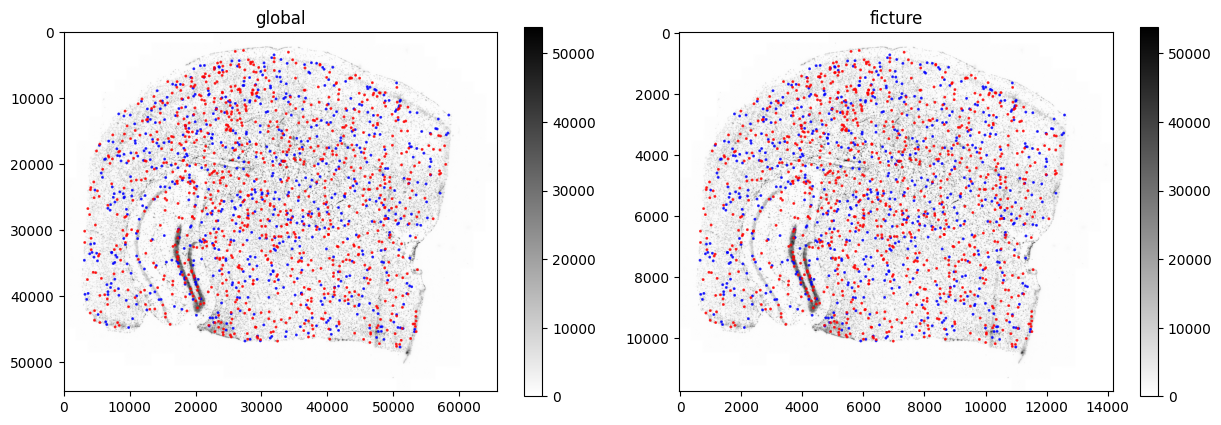

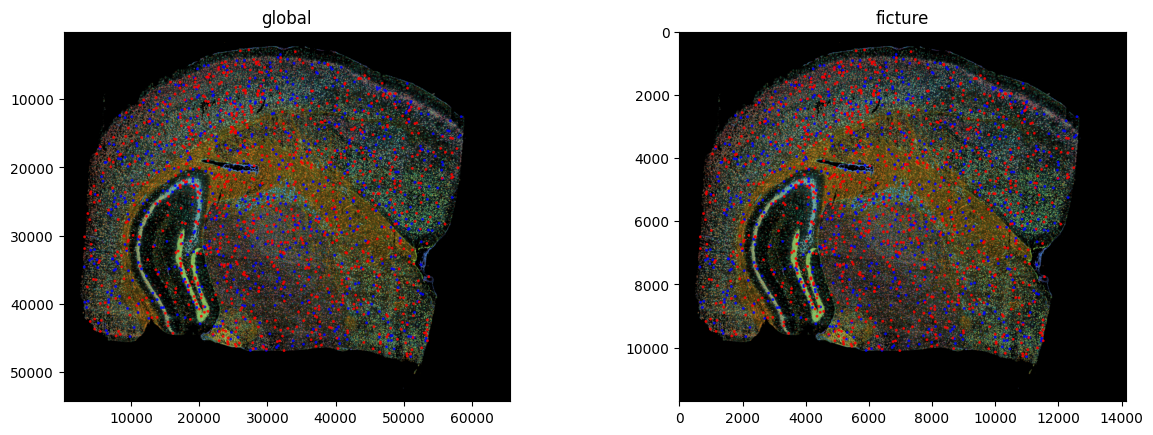

In [5]:
# check that transformations worked correctly - points should be overlapping the images. Red are pixel factors and blue are transcripts
sdata.pl.render_images(
    'slide2_region1_z3', channel='DAPI', scale='scale4', cmap='gray_r').pl.render_points(
    'slide2_region1_transcripts_sub', color='blue', alpha=0.5).pl.render_points(
    'slide2_region1_nF25_d6_pixel_factors_sub', color='red', alpha=0.5).pl.show()

sdata.pl.render_images(
    'slide2_region1_nF25_d6', scale='scale4').pl.render_points(
    'slide2_region1_transcripts_sub', color='blue', alpha=0.5).pl.render_points(
    'slide2_region1_nF25_d6_pixel_factors_sub', color='red', alpha=0.5).pl.show()

# TODO add plotting code for bounding box, cropping and plotting on subset here. Can show transcripts nad pixels colored by factor, and overlay ficture image with cells, transcripts etc .
# figure out if can also plot one gene only 

## High resolution plotting with spatial query 

In [7]:
# define bounding box for spatial query for high res plotting
bb_xmin = 10000
bb_ymin = 34000
bb_w = 3000
bb_h = 2000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

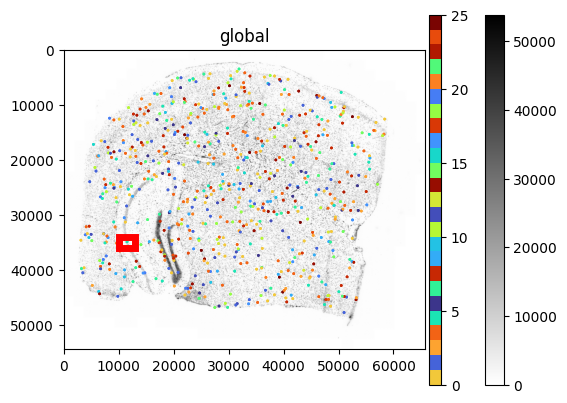

In [12]:
# plot cell segmentations and transcripts on whole slide
f, ax = plt.subplots()
sdata.pl.render_images(
    'slide2_region1_z3', channel='DAPI', scale='scale4', cmap='gray_r'
    ).pl.render_points(
    'slide2_region1_transcripts_sub', color='nF25_d6_factors', cmap=cmap,
    ).pl.show(coordinate_systems='global', ax=ax)

rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [28]:
# spatial crop of sdata to enable high-res plotting
cropped_sdata = sdata.subset(["slide2_region1_z3", "slide2_region1_nF25_d6_pixel_factors", "slide2_region1_transcripts", "slide2_region1_polygons", "slide2_region1_polygons_transformed"]).query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

cropped_sdata

SpatialData object
├── Images
│     └── 'slide2_region1_z3': DataTree[cyx] (7, 2000, 3000), (7, 1000, 1500), (7, 500, 750), (7, 250, 375), (7, 125, 187)
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     ├── 'slide2_region1_polygons': GeoDataFrame shape: (229, 9) (2D shapes)
│     └── 'slide2_region1_polygons_transformed': GeoDataFrame shape: (229, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (229, 500)
with coordinate systems:
    ▸ 'ficture', with elements:
        slide2_region1_z3 (Images), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)
    ▸ 'global', with elements:
        slide2_region1_z3 (Images), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes), slide2_region1_polygons

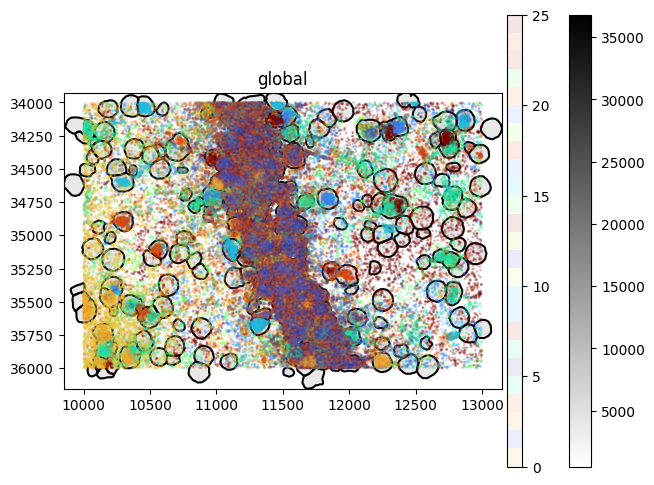

In [31]:
cropped_sdata.pl.render_images(
    'slide2_region1_z3', channel='DAPI', cmap='gray_r', alpha=1
    ).pl.render_shapes(
    'slide2_region1_polygons_transformed', outline_alpha=1, outline_color='black', fill_alpha=0.5,
    ).pl.render_points(
    'slide2_region1_transcripts', color='nF25_d6_factors', cmap=cmap, alpha=0.1, method='matplotlib',
    ).pl.show(coordinate_systems='global')

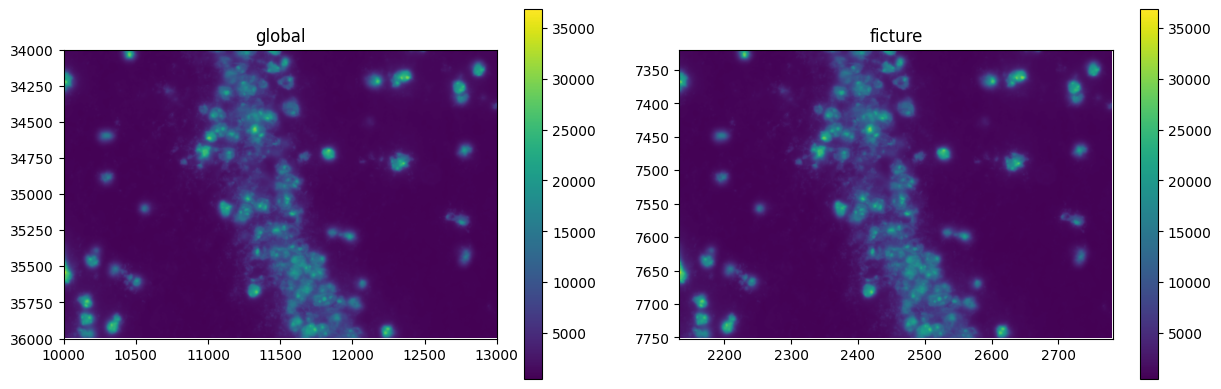

In [32]:
cropped_sdata.pl.render_images('slide2_region1_z3', channel='DAPI').pl.show()
